In [104]:
from pathlib import Path
import pathlib
import pandas as pd
import tarfile
import urllib.request

# Downloading the Data

In [105]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

# Data structure

In [106]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [107]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [108]:
housing.value_counts('ocean_proximity')

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [109]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


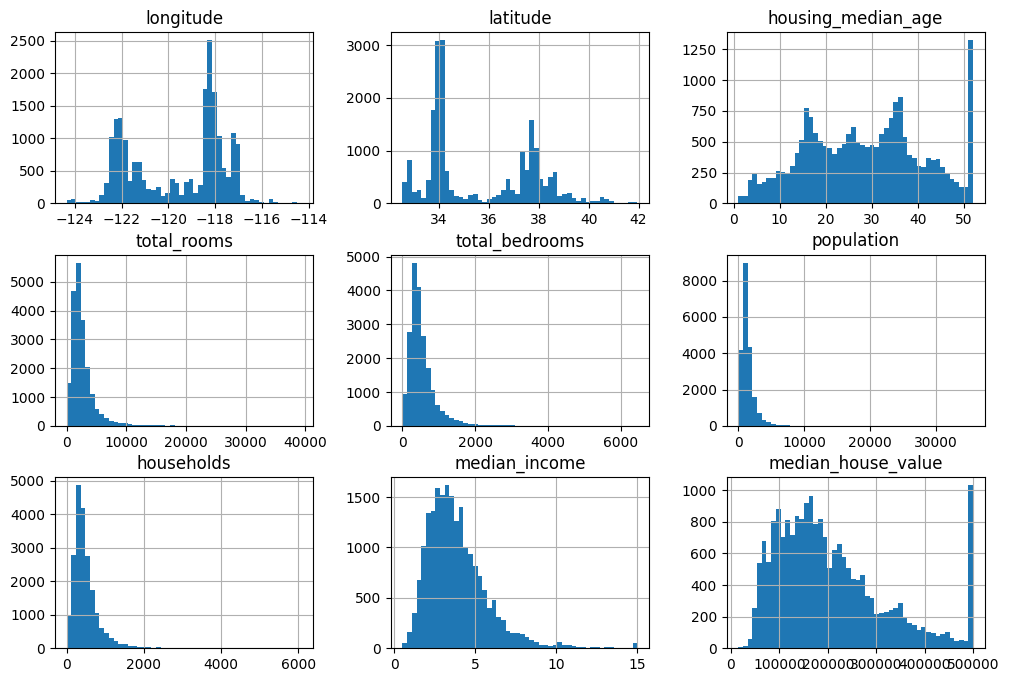

In [110]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(12, 8))
plt.show()

Creating a test set

In [111]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
#This works fine it shuffles and splits.
#But every time you run it np.random.permutation() creates a different shuffle. So test set keeps changing

In [112]:
train_set , test_set = shuffle_and_split_data(housing, 0.2)
len(test_set)

4128

In [113]:
len(train_set)

16512

In [114]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [115]:
housing_with_id = housing.reset_index()  # adds an `index` column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [116]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [117]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [118]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

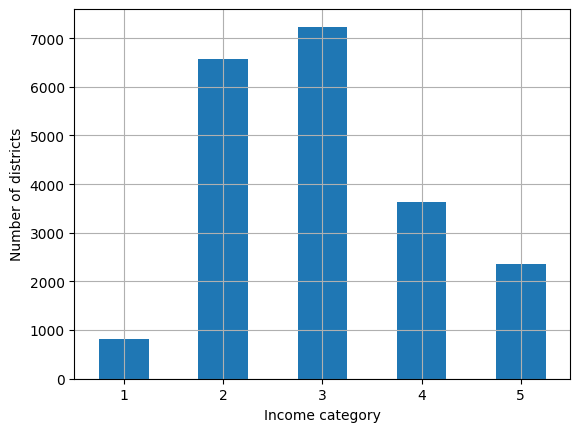

In [119]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [120]:
from sklearn.model_selection import StratifiedShuffleSplit # Splitting data by strata

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [121]:
strat_train_set, strat_test_set = strat_splits[0]

In [122]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42) # A simpler one-line method

In [123]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [124]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Discover and Visualize the Data to Gain Insights

In [125]:
housing = strat_train_set.copy()

# Visualizing Geographical Data

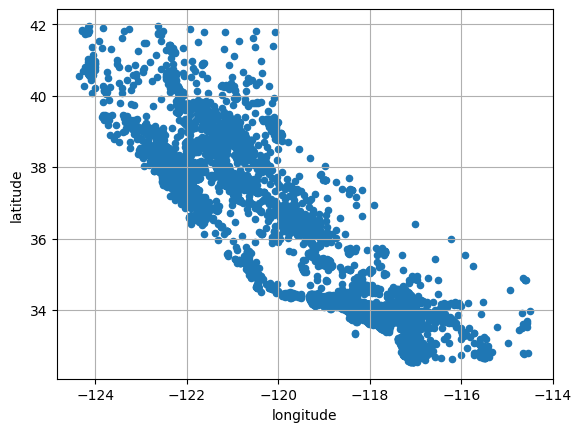

In [126]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

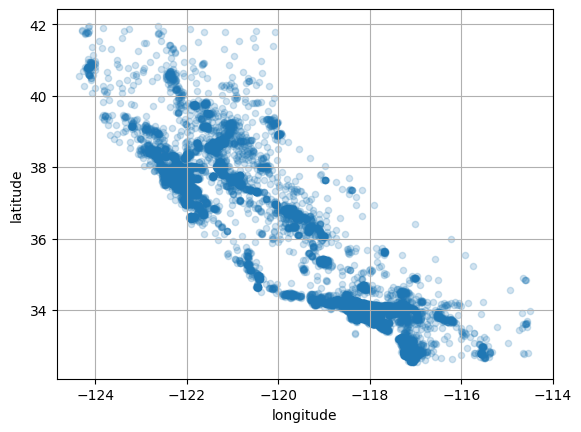

In [127]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

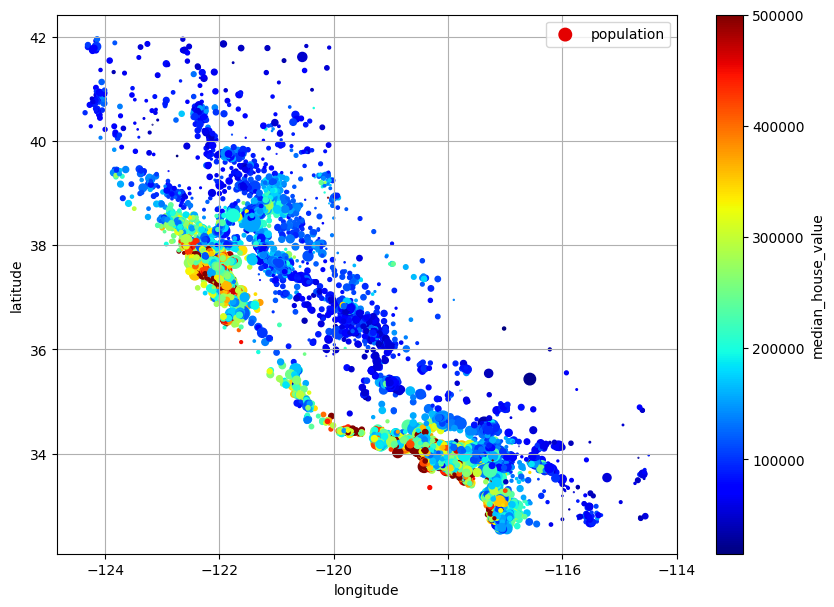

In [128]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

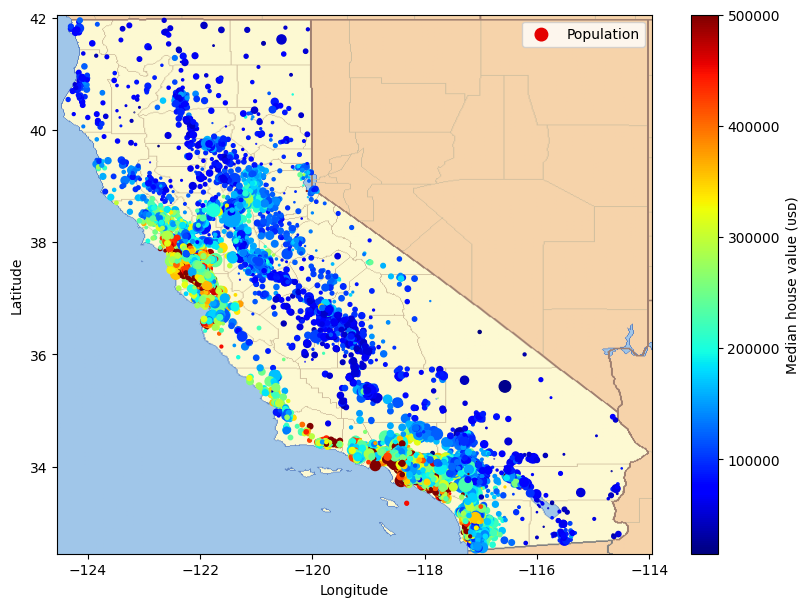

In [129]:
PROJECT_ROOT_DIR = pathlib.Path(".")
IMAGES_PATH = PROJECT_ROOT_DIR / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

plt.show()


# Looking for Correlations

In [130]:
corr_matrix = housing.corr(numeric_only=True)

In [131]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

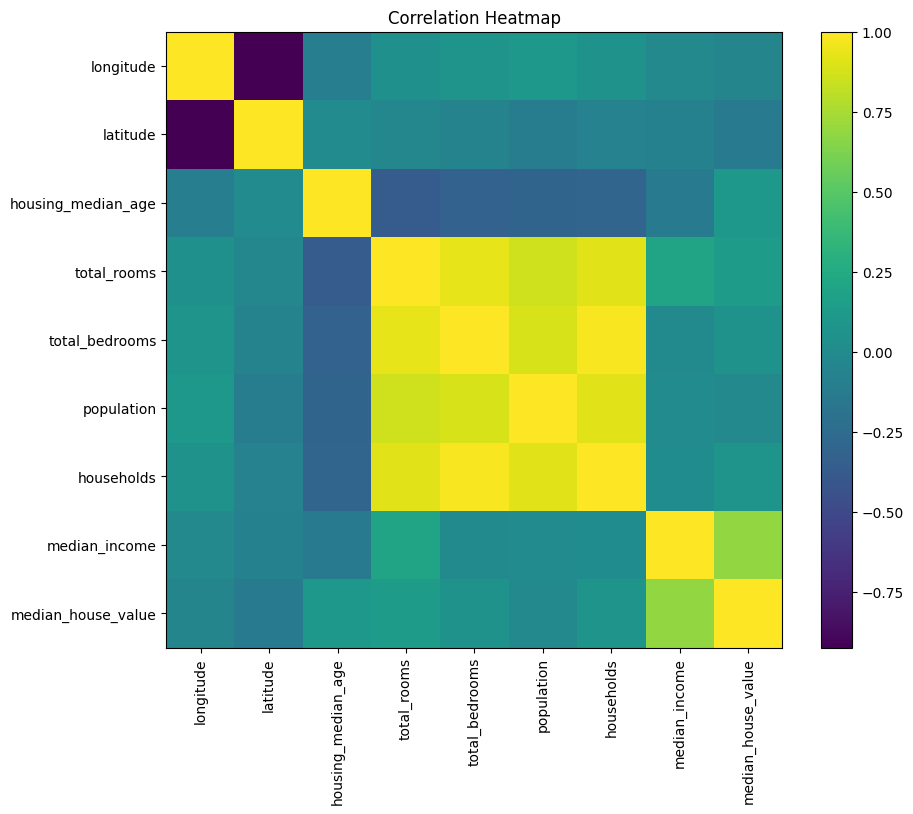

In [132]:
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, interpolation="nearest")
plt.title("Correlation Heatmap")
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.colorbar()
plt.show()

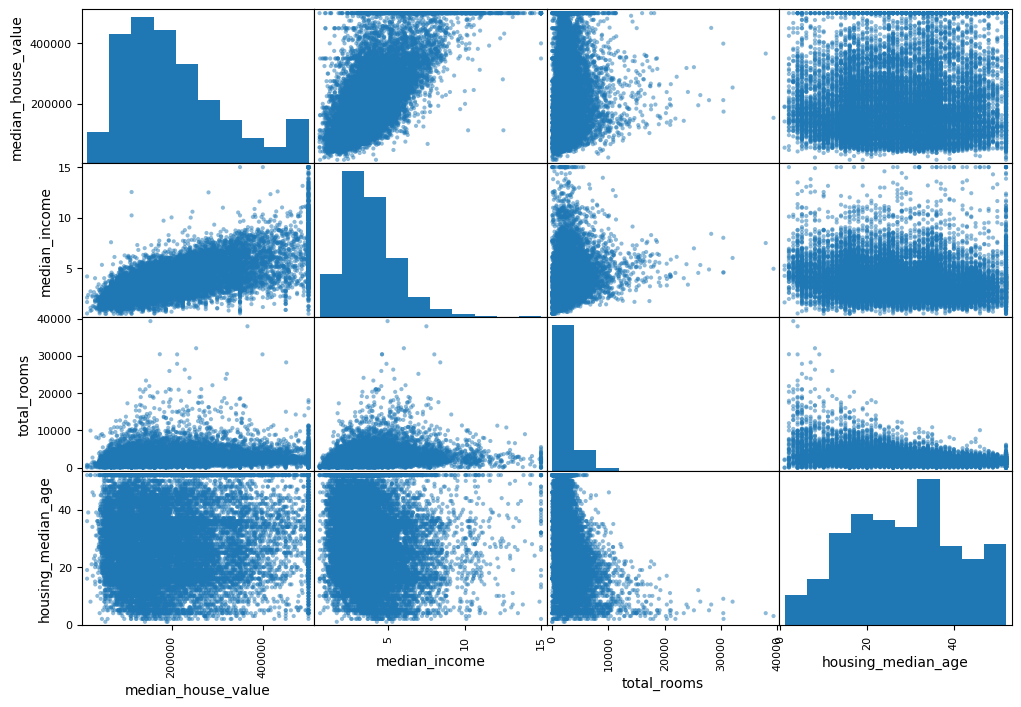

In [133]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

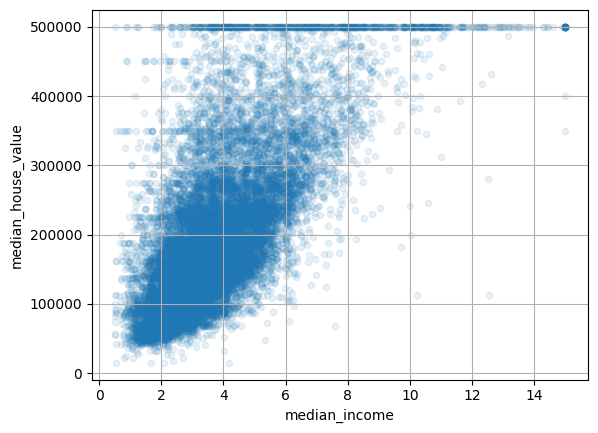

In [134]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
plt.show()

# Experimenting with Attribute Combinations

In [135]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [136]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

# Prepare the Data for Machine Learning Algorithms

In [137]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# Data Cleaning

In [138]:
housing.dropna(subset=["total_bedrooms"], inplace=True)  # option 1

housing.drop("total_bedrooms", axis=1)  # option 2

median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)

In [139]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

In [140]:
housing_num = housing.select_dtypes(include=[np.number])

In [141]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [142]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.5   ,  434.    , 1167.    ,
        408.5   ,    3.5409])

In [143]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.5   ,  434.    , 1167.    ,
        408.5   ,    3.5409])

In [144]:
X = imputer.transform(housing_num)

In [145]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [146]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

# Handling Text and Categorical Attributes


In [147]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [148]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [149]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [150]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [151]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [152]:
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16344 stored elements and shape (16344, 5)>

In [153]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [154]:
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [155]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [156]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [157]:
cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [158]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [159]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [160]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [161]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [162]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)

In [163]:
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


# Feature Scaling

In [164]:
from sklearn.preprocessing import MinMaxScaler

Min_Max_scaler = MinMaxScaler(feature_range=(-1,1))
housing_num_min_max_scaled =  Min_Max_scaler.fit_transform(housing_num)

In [165]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

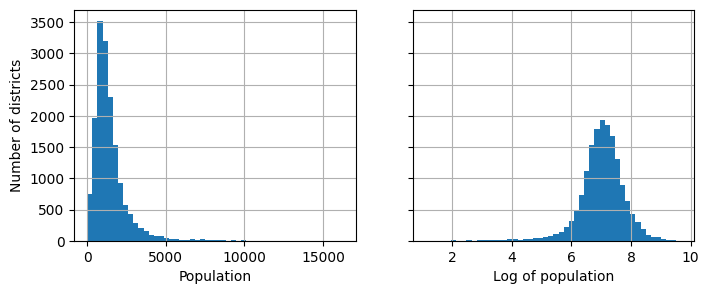

In [166]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
plt.show()

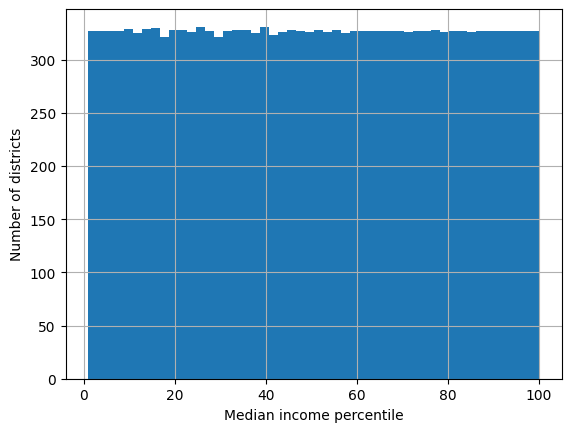

In [167]:
percentiles = [np.percentile(housing["median_income"], p)
               for p in range(1, 100)]
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()

In [168]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

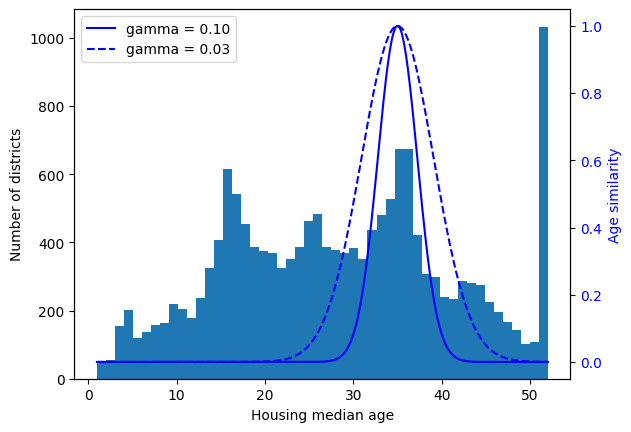

In [169]:
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
plt.show()

In [170]:
from sklearn.linear_model import LinearRegression

housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)

some_new_data = housing[["median_income"]].iloc[:5]

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [171]:
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [172]:
from sklearn.compose import TransformedTargetRegressor

mdoel = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[['median_income']], housing_labels)
predictions = model.predict(some_new_data)

In [173]:
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

# Custom Transformers


In [174]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[['population']])

In [175]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [176]:
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

In [177]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [178]:
sf_simil

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

In [179]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

In [180]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

In [181]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [182]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]])

In [183]:
similarities[:3].round(2)

array([[0.  , 0.97, 0.  , 0.  , 0.  , 0.08, 0.  , 0.  , 0.13, 0.57],
       [0.12, 0.  , 0.98, 0.03, 0.  , 0.  , 0.  , 0.54, 0.  , 0.  ],
       [0.  , 0.75, 0.  , 0.  , 0.  , 0.44, 0.  , 0.  , 0.27, 0.28]])

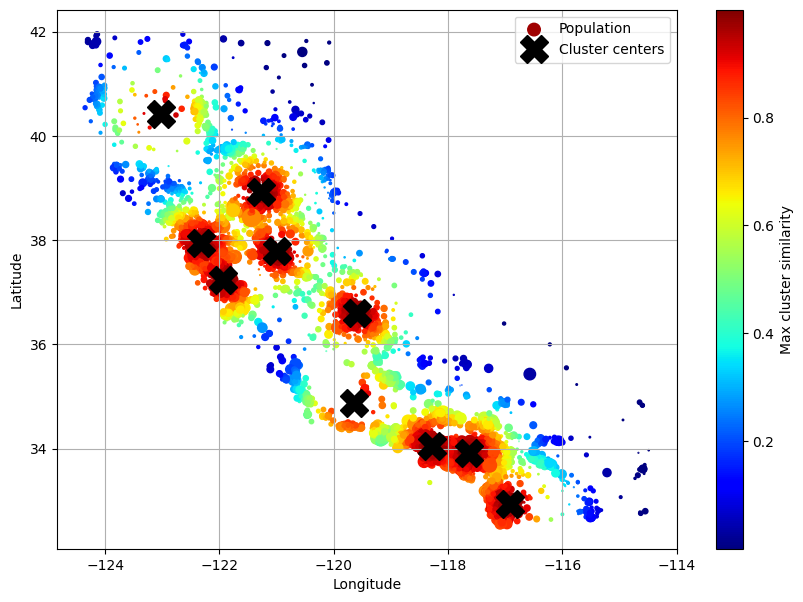

In [184]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
plt.show()

# Transformation Pipelines


In [185]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

In [186]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [187]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.36,  0.14,  1.4 , -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [188]:
def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
       correctly in Scikit-Learn 1.0.*."""
    from inspect import Signature, signature, Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
      print("Monkey-patching SimpleImputer.get_feature_names_out()")
      SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
                Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])

        def get_feature_names_out(self, names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self, names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self, names)

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out

monkey_patch_get_signature_names_out()

In [189]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)

In [190]:
df_housing_num_prepared.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.422634,1.013124,1.860687,0.310661,1.359094,0.137572,1.395732,-0.937557
14973,0.596681,-0.702274,0.907526,-0.308789,-0.436356,-0.693276,-0.373537,1.171380


In [191]:
num_pipeline[1]

StandardScaler()

In [192]:
num_pipeline[:-1]

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median'))])

In [193]:
num_pipeline.named_steps["simpleimputer"]

SimpleImputer(strategy='median')

In [194]:
num_pipeline.set_params(simpleimputer__strategy="median")

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [195]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [196]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [197]:
housing_prepared = preprocessing.fit_transform(housing)

In [198]:
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0


In [199]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [200]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [201]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

# Select and Train a Model

Training and Evaluating on the Training Set

In [202]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000022E68A067B0>)])),
                ('linearregression', LinearRegression())])

In [205]:
housing_predictions = lin_reg.predict(housing)

In [207]:
housing_predictions[:5].round(-2)

array([242800., 375900., 127500.,  99400., 324600.])

In [209]:
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-47.0%, -22.3%, 25.4%, 3.4%, -10.3%


In [208]:
try:
    from sklearn.metrics import root_mean_squared_error
except ImportError:
    from sklearn.metrics import mean_squared_error

    def root_mean_squared_error(labels, predictions):
        return mean_squared_error(labels, predictions, squared=False)

lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)
lin_rmse

68647.95686706626

In [210]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000022E68A067B0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [211]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions)
tree_rmse

0.0

# Better Evaluation Using Cross-Validation

In [212]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

In [213]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     67153.318273
std       1963.580924
min      63925.253106
25%      66083.277180
50%      66795.829871
75%      68074.018403
max      70664.635833
dtype: float64

In [214]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

In [215]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47002.931706
std       1048.451340
min      45667.064036
25%      46494.358345
50%      47093.173938
75%      47274.873814
max      49354.705514
dtype: float64

# Fine-Tune The Model

Grid Search

In [216]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000022E68A067B0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [217]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [218]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x0000022...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000022E6745AE40>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [219]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43536,43753,44569,43953
13,15,8,44084,44205,44863,44384
14,15,10,44368,44496,45200,44688
7,10,6,44251,44628,45857,44912
9,10,6,44251,44628,45857,44912


In [221]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [222]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022E67DF2090>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022E67DF1B50>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [223]:
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41115,42151,42695,41987
8,32,7,41604,42200,43219,42341
0,41,16,42106,42743,43443,42764
5,42,4,41812,42925,43557,42765
2,23,8,42421,43094,43856,43124


# Analyze the Best Models and Their Errors

In [224]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.06, 0.06, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.01, 0.01, 0.02,
       0.04, 0.01, 0.  , 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.  ,
       0.01, 0.  , 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.03, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.02, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

In [225]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(0.1898423270105783, 'log__median_income'),
 (0.07709175866873944, 'cat__ocean_proximity_INLAND'),
 (0.06455488601956336, 'bedrooms__ratio'),
 (0.056936146643377976, 'rooms_per_house__ratio'),
 (0.0490294770805355, 'people_per_house__ratio'),
 (0.038070690744923225, 'geo__Cluster 3 similarity'),
 (0.025643913400094476, 'geo__Cluster 22 similarity'),
 (0.021791275432437234, 'geo__Cluster 17 similarity'),
 (0.021575251507503695, 'geo__Cluster 6 similarity'),
 (0.017868654556924362, 'geo__Cluster 2 similarity'),
 (0.017431400050755975, 'geo__Cluster 32 similarity'),
 (0.015981159400591683, 'geo__Cluster 18 similarity'),
 (0.014888464257396877, 'geo__Cluster 40 similarity'),
 (0.014488389218107146, 'geo__Cluster 43 similarity'),
 (0.014252940099964142, 'geo__Cluster 7 similarity'),
 (0.014038173319370725, 'geo__Cluster 21 similarity'),
 (0.013846025114732157, 'geo__Cluster 38 similarity'),
 (0.01362570996472274, 'geo__Cluster 34 similarity'),
 (0.013547297167034428, 'geo__Cluster 41 simil

# Evaluate Your System on the Test Set

In [226]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = root_mean_squared_error(y_test, final_predictions)
print(final_rmse)

41549.20158097943


In [227]:
from scipy import stats

def rmse(squared_errors):
    return np.sqrt(np.mean(squared_errors))

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
boot_result = stats.bootstrap([squared_errors], rmse,
                              confidence_level=confidence, random_state=42)
rmse_lower, rmse_upper = boot_result.confidence_interval

In [228]:
rmse_lower, rmse_upper

(39579.4379532319, 43805.02861542037)

# Model persistence using joblib


Save the final model:



In [229]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']

In [ ]:
import joblib


from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

#class ClusterSimilarity(BaseEstimator, TransformerMixin):
#    [...]

final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)

In [231]:
predictions

array([439808.14, 455211.06, 109492.  ,  98208.  , 340021.04])